# New resolution tests informed by literature review

In [4]:
import importlib

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask

from modules import stats
import modules.regridding

importlib.reload(stats)
importlib.reload(modules.regridding)

from modules.regridding import Regridder

## Estimating the resolution necessary for accurate results

### Mean grid spacing: Grötzbach (1983) approximate conditions
Two different approximations give (for $\mathrm{Pr}=1$)
$$
    (\Delta x \Delta z)^{1/2} \lesssim 4.758\,\mathrm{Ra}^{-0.3205}
$$
and
$$
    (\Delta x \Delta z)^{1/2} \lesssim 5.23\,\mathrm{Ra}^{-0.3205}.
$$
At $\mathrm{Ra} = 10^9$ we get

In [2]:
5 * (1e9)**(-0.3205)

0.006523339843199475

whereas the mean grid spacing for a resolution of 1024 x 192 is

In [50]:
((8/1024)*(1/192))**(1/2)

0.00637887953849786

which, surprisingly, indicates that the current resolution satisfies the condition!

### Mean grid spacing: Grötzbach (1983) rigorous condition
Grötzbach argues that we have to resolve everything down the Kolmogorov length:
$$
    (\Delta x \Delta z)^{1/2} \leq \pi \eta
$$
Where the Kolmogorov length $\eta$ is defined by (Scheel, Emran and Schumacher 2013):
$$
    \eta \equiv \left( \frac{\mathrm{Pr}}{\mathrm{Ra}} \right)^{3/8}
        \langle \epsilon \rangle^{-1/4}
$$
and $\langle \epsilon \rangle$ is the spatial and temporal mean of the kinetic energy dissipation rate
$$
    \epsilon(\vec{x},t) \equiv \frac{1}{2}
        \left( \frac{\mathrm{Pr}}{\mathrm{Ra}} \right)^{1/2}
        \sum_{ij} \left(
            \frac{\partial u_i}{x_j} + \frac{\partial u_j}{x_i}
        \right)^2.
$$

I compute this using the last 50 time units of data from the highest-resolution run so far (1024 x 192):

In [41]:
data = xr.open_mfdataset(
    '../data/restest_highRa_v2/1024_192/*.nc',
    chunks={'t': 100, 'x': -1, 'z': -1}
)
data = data.isel(t=(data.t >= 50))

In [46]:
# Compute the Jacobian du_i/dx_j
jacobian = [[None, None], [None, None]]
coords = ['x', 'z']
components = [data.u, data.w]
for i in range(2):
    for j in range(2):
        jacobian[i][j] = components[i].differentiate(coords[j])

# Compute the sum
dissipation = 0
for i in range(2):
    for j in range(2):
        dissipation += (jacobian[i][j] + jacobian[j][i])**2

# average over space and time
dissipation = dissipation.integrate(['x', 'z', 't'])
for dim in ['x', 'z', 't']:
    dissipation /= data[dim].max() - data[dim].min()

# Multiply by 1/2 (Pr/Ra)^(1/2)
prandtl = 1
rayleigh = 1e9
dissipation *= 0.5*(prandtl/rayleigh)**0.5

# Calculate the Kolmogorov length
kolmogorov_length = (prandtl/rayleigh)**(3/8) * dissipation**(-1/4)
kolmogorov_length = kolmogorov_length.compute().item()

So according to Grötzbach the mean grid spacing should be

In [48]:
np.pi*kolmogorov_length

0.007259905950292136


which is only slightly larger than the approximate value of 0.0065 that we obtained before. Recall that our average grid spacing is

In [53]:
((8/1024)*(1/192))**(1/2)

0.00637887953849786

which, again, satisfies Grötzbach's condition!

### Number of points in thermal boundary layer
There must be sufficiently many vertical levels within the thermal boundary layer, which has thickness (Chillà and Schumacher 2012)
$$
    \delta_T = \frac{1}{2\,\mathrm{Nu}(z=0)} = -\frac{1}{2} \left( \left. \frac{\partial \langle \theta \rangle _{A,t}}{\partial z} \right|_{z=0} \right)^{-1}
$$
where $\langle \cdot \rangle _{A,t}$ denotes denotes horizontal and temporal averaging. I find $\delta_T$ to be

In [103]:
profile = data.theta.mean(['x', 't']).compute()
lapse_rate = -profile.differentiate('z')
bl_thickness = 0.5/lapse_rate.isel(z=0)
print(bl_thickness.item())

0.010832330805456187


and visualise this value on a plot of the temperature profile:

[Text(0.5, 0, '$\\langle \\theta \\rangle _{A,t}$'), Text(0, 0.5, '$z$')]

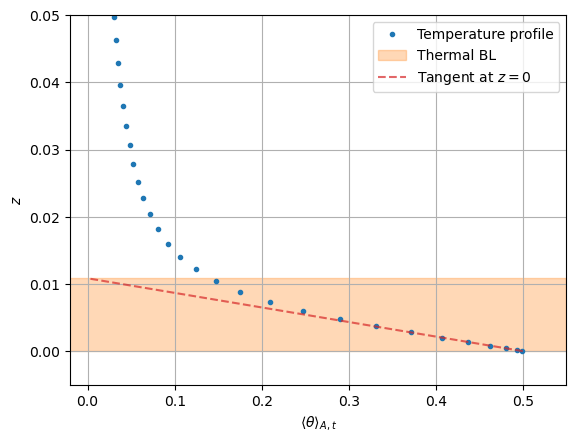

In [98]:
z = np.linspace(0, bl_thickness, 10)
fig, ax = plt.subplots()
ax.plot(profile, profile.z, '.', label='Temperature profile')
ax.fill_between(
    ax.get_xlim(), 0, bl_thickness, color='tab:orange', alpha=0.3,
    label='Thermal BL'
)
ax.plot(
    0.5 - lapse_rate.isel(z=0).item()*z, z, '--', color='tab:red', alpha=0.7,
    label='Tangent at $z=0$'
)
ax.set_xlim(-0.02, 0.55)
ax.set_ylim(-0.005, 0.05)
ax.grid()
ax.legend()
ax.set(xlabel=r'$\langle \theta \rangle _{A,t}$', ylabel='$z$')

Indeed, there are

In [101]:
(data.z <= bl_thickness).sum().item()

13

vertical levels in the thermal boundary layer. Grötzbach (1983) recommended only 3, and Shishkina et al. (2010) recommended 9 for $\mathrm{Ra} = 2 \times 10^9$ based on a theoretical argument.

### Conclusion
According to the basic conditions available in the literature, a 1024 x 192 grid should be producing a reasonably accurate solution.

## Resolution dependence tests

### Nusselt number
Scheel, Emran, and Schumacher (2013):
$$
\mathrm{Nu}(z,t) \equiv (\mathrm{Ra}\,\mathrm{Pr})^{1/2} \langle w \theta \rangle _A
    - \frac{\partial \langle \theta \rangle _A}{\partial z}.
$$